# Machine-Learning-and-Statistics-Project 2020

***

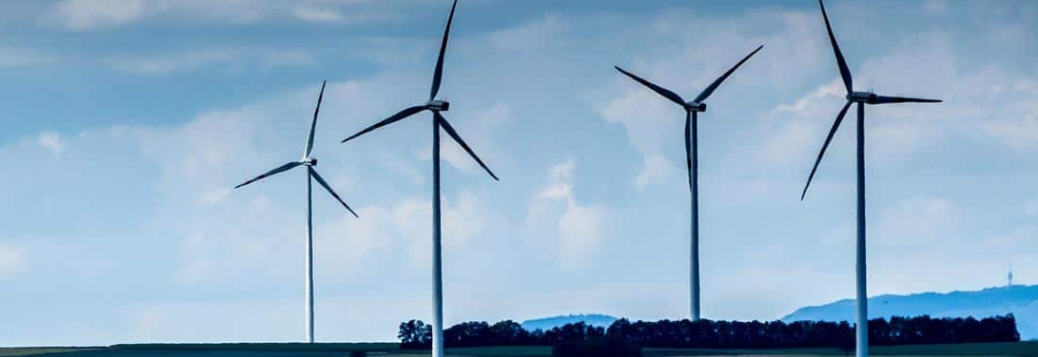

## Introduction

The goal of this project is to produce a model that accurately predicts wind turbine power output from wind speed values. A web service that responds with predicted power values based on speed values sent as HTTP requests is also included. 
This is based on the data set powerproduction. 

#### Task objectives:
- Understand how wind turbines operate.
- Explore the Power production dataset.
- Explore models.
- Determine model to use.
- Develop web service.

### How do wind turbines operate?

The ESB provide detail on how wind turbines operate.  They operate automatically, self-starting when the wind speed reaches an average of about three to five metres per second (about 10 mph), equal to that of a gentle breeze which otherwise would only be strong enough to rustle leaves and light twigs. The output increases linearly with the wind speed until the wind speed reaches 13 to 14 metres per second (about 30 mph) equal to that of a strong breeze. At this point, the wind turbine will reach its maximum generating capacity.

If the average wind exceeds the maximum operational limit of 25 meters per second, equal to that of a storm, the wind turbine shuts down by the feathering of blades, in order to avoid excessive wear-and-tear. Upon the average wind speed dropping back below 25 m/s the wind turbine will restart. [6]

### Explore the dataset

In [1]:
# Import libraries
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np

In [2]:
# Make matplotlib show interactive plots in the notebook.
%matplotlib inline

# Apply the default seaborn settings.
sns.set()

#Set plot style.
plt.style.use("ggplot")

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

In [3]:
# Import the power production dataset and call it pp
pp = pd.read_csv("powerprod.csv")

In [4]:
pp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,500.0,12.590398,7.224991,0.0,6.32475,12.5505,18.77525,25.000
power,500.0,48.014584,41.614572,0.0,5.28800,41.6455,93.53700,113.556


In [5]:
pp.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


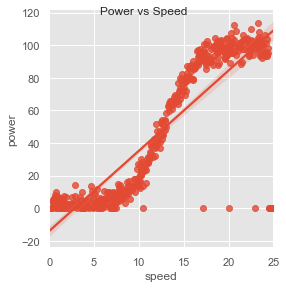

In [6]:
p = sns.pairplot(data=pp,y_vars=['power'],x_vars=['speed'],kind='reg',height=4).fig.suptitle('Power vs Speed')

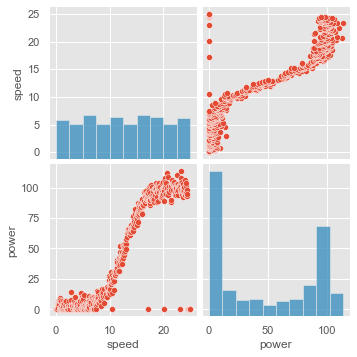

In [7]:
sns.pairplot(pp)

### Observations

The powerproduction dataset correlates with information provided by the ESB on how turbines operate:

- Once speed hits 3 - 5 m/s, they start to operate.
- Output increases linearly until 25 m/s which is maximum capacity.
- Turbines shut down once the maximum limit has been reached.

A linear correlation is clear once the turbine is fully operational (approx 10 - 25 m/s).<br>

#### Should certain data points be excluded?
 
In his "Deep learning with Python" book, Francois Chollet [9] says that "In general, with neural networks, it’s safe to input missing values as 0, with the condition that 0 isn’t already a meaningful value. The network will learn from exposure to the data that the value 0 means missing data and will start ignoring the value."

Due to operational constraints of the turbines, I believe it makes sense to include only data points  when they are operational.  The max value in 25 m/s (per the summary table  above) so values below 3 need to be excluded (minimum start point). There are also a number of data points with zero power output.  This is likely due to maintenance so these will also be excluded.  In summary the following will be excluded:

- Speed below 3 m/s.
- Power output of zero.
This means that we are excluding 88 data points approximately 18% of the dataset. 

In [8]:
# Adapted from https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior
j = pp[(pp.speed < 3) | (pp.power == 0)]
j.count()

speed    88
power    88
dtype: int64

In [9]:
# Adapted from https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior
# Exclude values less than 3 m/s & zero power output.
pp1 = pp[(pp.speed > 3) & (pp.power != 0)]
pp1

,speed,power
56,3.003,3.578
57,3.028,2.633
58,3.053,2.836
59,3.078,3.063
61,3.203,1.360
...,...,...
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223


In [10]:
pp1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,412.0,14.102507,6.092924,3.003,8.85275,14.3515,19.17525,24.399
power,412.0,57.855840,39.359088,0.067,13.13475,68.4240,95.60025,113.556


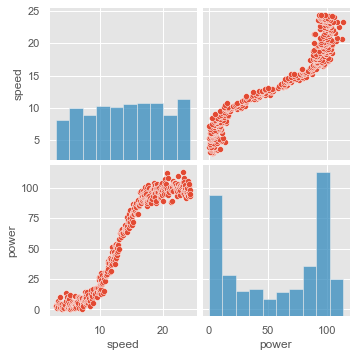

In [11]:
sns.pairplot(pp1)

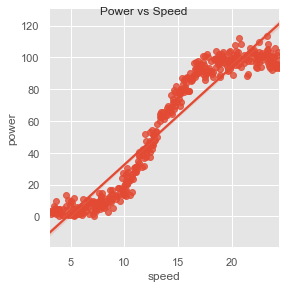

In [12]:
p = sns.pairplot(data=pp1,y_vars=['power'],x_vars=['speed'],kind='reg',height=4).fig.suptitle('Power vs Speed')

The data is much cleaner and models can be explored

***

## Explore models
Every machine learning algorithm works best under a given set of conditions. Finding the appropriate algorithm that meets requirements ensures superior performance. Time to find an appropriate algorithm.

### Linear Regression Model

Linear regression is a statistical model that examines the linear relationship between variables, a dependent variable and independent variable.  Regression models describe the relationship between variables by fitting a line to the observed data. Regression allows estimation  of how a dependent variable changes as the independent variable changes. For the label "power" (Y) and feature "wind" X1", the linear regression model is the form of:

$$Y=β0+β1X1+β2X2+ ... +βpXp$$
The β terms are unknown coefficients that will be determined by our specific data set. The correlation coefficient indicates the strength of the relationship between the independent and the dependent variable whereas the coefficient of determination (r-squared) explains to what extent the variance of the independent variable explains the variance of the dependent variable.

A correlation coefficient close to 1 indicates a positive relationship between the independent and the dependent variable and a coefficient of determination closer to 1 indicates a good fit of data to the predictive model.

In [13]:
# Import libraries
import sklearn.linear_model as lin

In [14]:
# Assign features and labels to the working data set
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

#### Train the Model
Build the linear regression model using the training data. This involves creating a Linear Regression model object and one call to its 'fit' method.

In [15]:
model = lin.LinearRegression()
model.fit(x, y)

LinearRegression()

#### Interpreting The Coefficients
The intercept term  is equal to the mean power output when all of the other coefficients are set equal to their mean values.  A positive coefficient means that power output increases as speed increases which we know from our original review of the dataset. 

In [16]:
r = model.score(x, y)
p = [model.intercept_, model.coef_[0]]

In [17]:
# The intercept (often labeled the constant) is the expected mean value of Y when all X=0. 
r

0.908714038323946

In [18]:
p

[-28.986042307282617, 6.157903724446237]

### Predict
Now that the model is built, its performance can be tested by using the 'predict' function within the LinearRegression model class.

Text(0, 0.5, 'Predicted Power (kWh)')

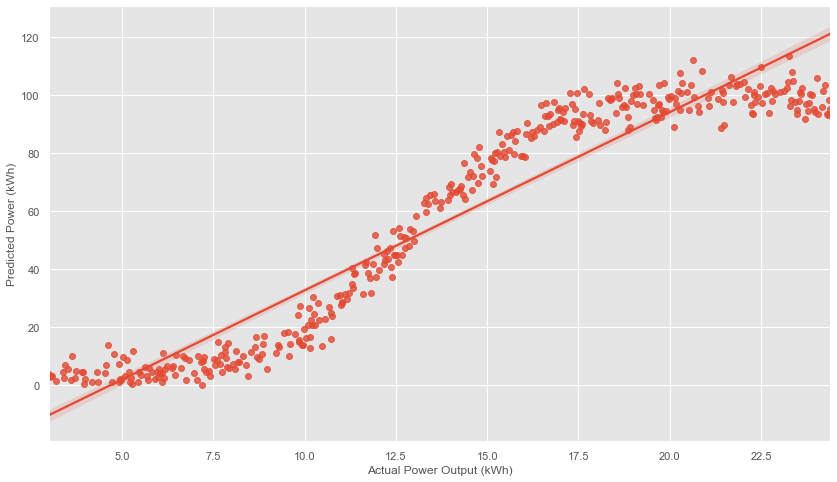

In [19]:
sns.regplot(x=x, y=y)
plt.xlabel('Actual Power Output (kWh)')
plt.ylabel('Predicted Power (kWh)')

In [20]:
# Adapted from https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/models.ipynb 
def f(x, p):
    return p[0] + x * p[1]

In [21]:
f(20, p)

94.17203218164212

#### Conclusion

This plot tells us that our model Linear regression does not suit. Linear regression is not very flexible and not very accurate due to its rigidity. The model does not capture underlying relationship between the power and speed.

### Polynomial Regression
Polynomial regression is another form of regression in which the maximum power of the independent variable is more than 1. In this regression technique, the best fit line is not a straight line instead it is in the form of a curve.

Quadratic regression, or regression with second order polynomial, is given by the following equation:

$$Y =Θ1 +Θ2*x +Θ3*x2$$
Quadratic regression fits the data better than linear regression. 

In [22]:
# Assign features and labels to the working data set
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
x_poly = poly_reg.fit_transform(x)

In [24]:
x_poly

array([[  1.      ,   3.003   ,   9.018009],
       [  1.      ,   3.028   ,   9.168784],
       [  1.      ,   3.053   ,   9.320809],
       ...,
       [  1.      ,  24.349   , 592.873801],
       [  1.      ,  24.374   , 594.091876],
       [  1.      ,  24.399   , 595.311201]])

In [25]:
lin_reg2 = LinearRegression()
lin_reg2.fit(x_poly,y)

LinearRegression()

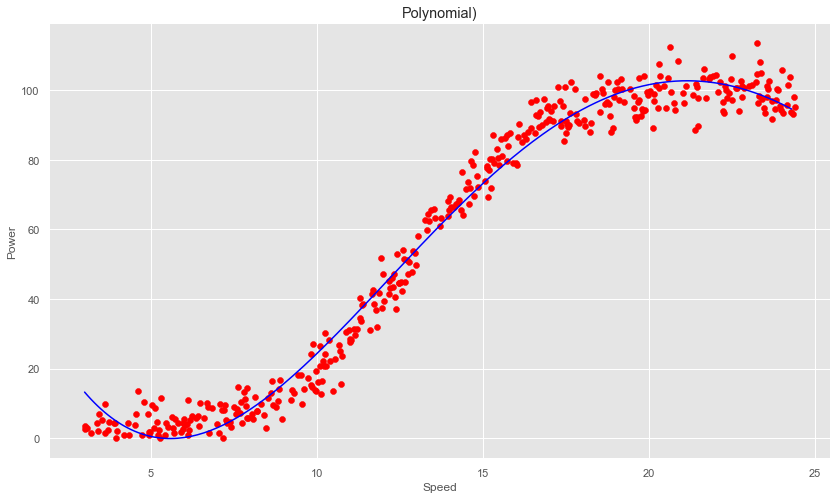

In [26]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(x)
lin_reg2 = LinearRegression()
lin_reg2.fit(x_poly,y)
 
x_grid = np.arange(min(x),max(x),0.1)
x_grid = x_grid.reshape(len(x_grid),1) 
plt.scatter(x,y, color='red') 
 
plt.plot(x_grid, lin_reg2.predict(poly_reg.fit_transform(x_grid)),color='blue') 
 
plt.title("Polynomial)")
plt.xlabel('Speed')
plt.ylabel('Power')
plt.show()

In [27]:
#lin_reg2.predict(poly_reg.fit_transform([20]))

### Random Forest
Random forest regression is an ensemble learning technique. 
In ensemble learning, you take multiple algorithms or same algorithm multiple times and put together a model that’s more powerful than the original.

Prediction based on the trees is more accurate because it takes into account many predictions. This is because of the average value used. These algorithms are more stable because any changes in dataset can impact one tree but not the forest of trees.


Steps to perform the random forest regression
This is a four step process and our steps are as follows:

-Pick a random K data points from the training set.
- Build the decision tree associated to these K data points.
- Choose the number N tree of trees you want to build and repeat steps 1 and 2.
- For a new data point, make each one of your Ntree trees predict the value of Y for the data point in the question, and assign the new data point the average across all of the predicted Y values.
- Implementing Random Forest Regression in Python
- Our goal here is to build a team of decision trees, each making a prediction about the dependent variable and the ultimate prediction of random forest is average of predictions of all trees.

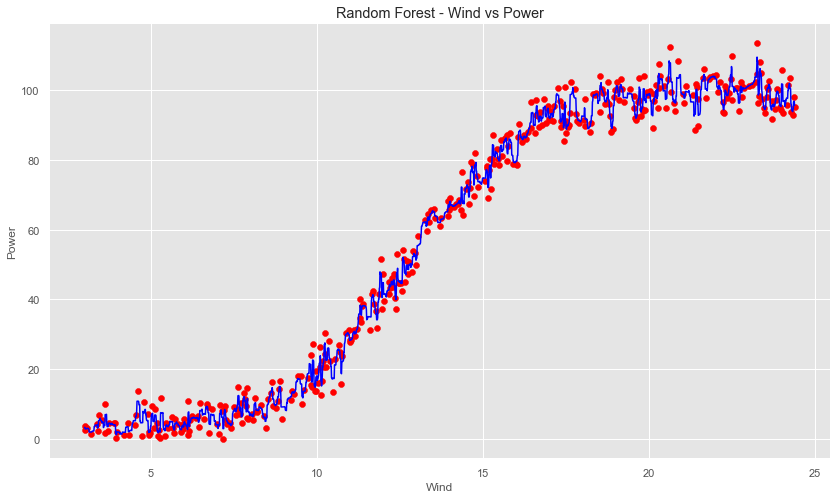

In [28]:
# Adapted from https://www.askpython.com/python/examples/random-forest-regression

# for 300 trees
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 2)
regressor.fit(x,y)
 
#higher resolution graph
x_grid = np.arange(min(x),max(x),0.01)
x_grid = x_grid.reshape(len(x_grid),1) 
  
plt.scatter(x,y, color='red') #plotting real points
plt.plot(x_grid, regressor.predict(x_grid),color='blue') #plotting for predict points
  
plt.title("Random Forest - Wind vs Power")
plt.xlabel('Wind')
plt.ylabel('Power')
plt.show()


### Interpretation of the above graph
We get many steps in this graph than with one decision tree. We have a lot more of intervals and splits. We get more steps in our stairs.

Every prediction is based on 10 votes (we have taken 10 decision trees). Random forest calculates many averages for each of these intervals.

The more number of trees we include, more is the accuracy because many trees converge to the same ultimate average.

In [29]:
 
y_pred=regressor.predict([[20]])
y_pred

array([98.797498])

### Keras Neural network

#### Create Keras Model

Models in Keras are defined as a sequence of layers.  A sequential model is created with layers added until the network architecture is working properly.

The input layer needs the right number of input features. This can be specified when creating the first layer with the input_dim argument.

Fully connected layers are defined using the Dense class. We can specify the number of neurons or nodes in the layer as the first argument, and specify the activation function using the activation argument.

In [30]:
import tensorflow.keras as kr

In [31]:
# Adapted from https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb
# Create a new neural network.
m = kr.models.Sequential()

# Add multiple layers, initialised with weight and bias.
m.add(kr.layers.Dense(66, input_dim=1, activation="relu",kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
m.add(kr.layers.Dense(32, activation='sigmoid'))
m.add(kr.layers.Dense(16, activation='sigmoid'))
m.add(kr.layers.Dense(1, activation=None))

#### Compile Model

Compiling the model automatically chooses the best way to represent the network for training and making predictions.

Training a network means finding the best set of weights to map inputs to outputs in our dataset.

The loss function is specified to evaluate a set of weights, the optimizer is used to search through different weights for the network and any optional metrics we would like to collect and report during training.

The Mean Squared Error, or MSE, loss is the default loss to use for regression problems.

The optimizer as the efficient stochastic gradient descent algorithm “adam“. This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems. 

In [32]:
# Compile the model.
m.compile(loss="mean_squared_error", optimizer="adam")

### Fit the model

Training occurs over epochs and each epoch is split into batches.

Epoch: One pass through all of the rows in the training dataset.
Batch: One or more samples considered by the model within an epoch before weights are updated.
One epoch is comprised of one or more batches, based on the chosen batch size and the model is fit for many epochs. 

What is the Difference Between a Batch and an Epoch in a Neural Network?
The training process will run for a fixed number of iterations through the dataset called epochs, that we must specify using the epochs argument. We must also set the number of dataset rows that are considered before the model weights are updated within each epoch, called the batch size and set using the batch_size argument.

These configurations can be chosen experimentally by trial and error. We want to train the model enough so that it learns a good (or good enough) mapping of rows of input data to the output classification. The model will always have some error, but the amount of error will level out after some point for a given model configuration. This is called model convergence.

By looking at the numbers, you should be able to see the loss decrease and the accuracy increase over time. At this point, you can experiment with the hyper-parameters and neural network architecture. Ru

In [33]:
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

In [ ]:
# fit the keras model on the dataset
m.fit(x, y, epochs=500, batch_size=12)
m.summary()

Epoch 1/500
35/35 [==============================] - 1s 2ms/step - loss: 4962.0172
Epoch 2/500
35/35 [==============================] - 0s 2ms/step - loss: 4715.1199
Epoch 3/500
35/35 [==============================] - 0s 2ms/step - loss: 4469.0520
Epoch 4/500
35/35 [==============================] - 0s 2ms/step - loss: 4637.9531
Epoch 5/500
35/35 [==============================] - 0s 2ms/step - loss: 4389.9582
Epoch 6/500
35/35 [==============================] - 0s 2ms/step - loss: 4773.7329
Epoch 7/500
35/35 [==============================] - 0s 2ms/step - loss: 4461.1415
Epoch 8/500
35/35 [==============================] - 0s 2ms/step - loss: 4583.6386
Epoch 9/500
35/35 [==============================] - 0s 2ms/step - loss: 4108.4363
Epoch 10/500
35/35 [==============================] - 0s 2ms/step - loss: 4534.1700
Epoch 11/500
35/35 [==============================] - 0s 2ms/step - loss: 4254.3112
Epoch 12/500
35/35 [==============================] - 0s 2ms/step - loss: 4150.2130
E

35/35 [==============================] - 0s 1ms/step - loss: 2375.7236
Epoch 99/500
35/35 [==============================] - 0s 1ms/step - loss: 2378.5269
Epoch 100/500
35/35 [==============================] - 0s 1ms/step - loss: 2178.6627
Epoch 101/500
35/35 [==============================] - 0s 1ms/step - loss: 2257.7645
Epoch 102/500
35/35 [==============================] - 0s 1ms/step - loss: 2258.3240
Epoch 103/500
35/35 [==============================] - 0s 1ms/step - loss: 2299.0006
Epoch 104/500
35/35 [==============================] - 0s 1ms/step - loss: 2370.1907
Epoch 105/500
35/35 [==============================] - 0s 1ms/step - loss: 2072.8643
Epoch 106/500
35/35 [==============================] - 0s 1ms/step - loss: 2168.1670
Epoch 107/500
35/35 [==============================] - 0s 1ms/step - loss: 2172.6911
Epoch 108/500
35/35 [==============================] - 0s 1ms/step - loss: 2261.0740
Epoch 109/500
35/35 [==============================] - 0s 1ms/step - loss: 2114.

### Evaluate 
We have trained our neural network on the entire dataset and we can evaluate the performance of the network on the same dataset.

This will only give us an idea of how well we have modeled the dataset (e.g. train accuracy), but no idea of how well the algorithm might perform on new data. We have done this for simplicity, but ideally, you could separate your data into train and test datasets for training and evaluation of your model.

You can evaluate your model on your training dataset using the evaluate() function on your model and pass it the same input and output used to train the model.

This will generate a prediction for each input and output pair and collect scores, including the average loss and any metrics you have configured, such as accuracy.

The evaluate() function will return a list with two values. The first will be the loss of the model on the dataset and the second will be the accuracy of the model on the dataset. We are only interested in reporting the accuracy, so we will ignore the loss value.

In [ ]:
scores = m.evaluate(x, y, verbose=0)
print(scores)
# print("%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

#### Predict

In [ ]:
result = m.predict([20])
#type(result[0])
#result = np.ndarray.item(result[0])
result

In [ ]:
# Plot Data and Predictions to Visualise
plt.plot(x, y, label='Actual Power')
plt.plot(x, m.predict(x), label='Predicted Power')
plt.legend()

### Conclusion

Keras is a flexible neural network.  It appears very accurate.




### Choosing an Appropriate Model
Choosing an appropriate model depends on a number of factors, including:

- The size of the data, as some models perform better on larger or smaller data sets

- The distribution of the data, as some models assume the features with a dataset follow a specific statistical distribution

- The relationship between the features and labels (linear or non-linear, additive or multiplicative, etc.)
Wind turbines produce electricity approximately 85% of the time. The other 15% of the time they are not turning for reasons, such as: very low wind speeds, very high wind speeds, and maintenance/repair work.


The general goal of machine learning is to build models that can learn from data without being explicitly programmed. Supervised learning refers to the fact that each sample within the data being used to build the system contains an associated label. The goal is to build a model that can accurately predict the value of the label when presented with new data. The supervised learning model takes the form:

Y=f(x)
   
Where the label is assumed to be some general function of the input features. 

Power curve of a wind turbine depicts the relationship between output power and wind speed.  Accurate models of power curves can play an important role in improving the performance of wind energy based systems. This notebook presents a detailed review of different approaches for modelling the wind turbine power curve. [1]



***

## References
[1] https://www.hindawi.com/journals/jen/2016/8519785/<br>
[2] http://ieeexplore.ieee.org/iel7/5165391/5433168/06894235.pdf <br>
[3] https://keras.io/getting_started/intro_to_keras_for_engineers <br>
[4] https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf <br>
[5] https://blogs.oracle.com/datascience/supervised-learning-with-python<br>
[6] https://scikit-learn.org/stable/index.html <br>
[7] https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb<br>
[8] https://www.esb.ie/tns/education-hub/future-energy/wind-energy<br>
[9] http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf Deep Learning with Python by Francois Chollet <br>
[10] https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior <br>
[11] https://www.askpython.com/python/examples/random-forest-regression

### The End